# Import Library

In [688]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from copy import deepcopy

# Classes and Function

In [689]:
class Point: 
    def __init__(self, id, x, y, partition):
        self.id = id
        self.partition = partition
        self.x = x
        self.y = y 

    def get_pos(self):
        return self.x, self.y

In [690]:
class Graph: 
    def __init__(self, points = {}, weight = np.array([[]])): 
        self.points = points
        self.weight = weight
        self.all_weight = weight

    def get_points(self):
        return self.points        
        
    def get_partition_points(self, partition):
        temp = {}
        for i in self.points: 
            if self.points[i].get('partition') == partition: 
                temp[i] = self.points[i]
                
        return temp

    def get_partition(self):
        partition_result = np.array([])
        for i in self.points:
            partition_result = np.append(partition_result, self.points[i].get('partition'))

        return partition_result

        
    def get_points_coords(self): 
        points_x = np.array([])
        points_y = np.array([])

        for i in self.points:
            points_x = np.append(points_x, self.points[i].get('x'))
            points_y = np.append(points_y, self.points[i].get('y'))

        return points_x, points_y
    
    def get_partition_points_coords(self, partition):
        points_x = np.array([])
        points_y = np.array([])

        for i in self.get_partition_points(partition):
            points_x = np.append(points_x, self.points[i].get('x'))
            points_y = np.append(points_y, self.points[i].get('y'))

        return points_x, points_y

    def get_weight(self):
        return self.weight

    def get_spread(self):
        points_x, points_y = self.get_points_coords()
        return max(max(points_x) - min(points_y), max(points_y) - min(points_y))

    def get_partition_spread(self, partition):
        points_x, points_y = self.get_partition_points_coords(partition)
        if(len(points_x) == 0):
            return 0
        return max(max(points_x) - min(points_y), max(points_y) - min(points_y))

    def get_edge_cut(self):
        edge_cut = {}
        size = len(self.points)
        for i in range(size):
            for j in range(i, size):
                if(weight[j, i] != 0 and self.points[i].get('partition') != self.points[j].get('partition')):
                    edge_cut[(j, i)] = weight[j, i]
        return edge_cut

    def get_partition_size(self, partition):
        points_x, _ = self.get_partition_points_coords(partition)
        return len(points_x)

    def is_connected(self):
        if(self.weight.size == 0): 
            return False
            
        num_vertices = len(self.points)

        def dfs(vertex, visited):
            visited[vertex] = True
            for neighbor in range(num_vertices):
                if self.weight[vertex, neighbor] != 0 and not visited[neighbor]:
                    dfs(neighbor, visited)

        visited = [False] * num_vertices

        dfs(0, visited)

        return all(visited) 

    def is_partition_connected(self, partition):
        if(self.weight.size == 0): 
            return False
        
        num_vertices = len(self.get_partition_points(partition))

        def dfs(vertex, visited, idx=-1):
            visited[idx] = True
            for i, neighbor in enumerate(self.get_partition_points(partition)):
                if self.weight[vertex, neighbor] != 0 and not visited[i]:
                    dfs(neighbor, visited, i)

        visited = [False] * num_vertices
        dfs([v for v in self.get_partition_points(partition)][0], visited, 0)

        return all(visited)          

    def calculate_weight(self, min_s, max_s):
        iteration = 0
        points_x, points_y = self.get_points_coords()
        size = len(points_x)
        temp = np.zeros([size, size])
        for i in range(size):
            for j in range(size):
                temp[i, j] = np.sqrt(np.abs(points_x[i] - points_x[j]) ** 2 + np.abs(points_y[i] - points_y[j]) ** 2)
        
        self.all_weight = np.copy(temp)
        self.weight = np.zeros([size, size])
        while(not self.is_connected()):
            iteration += 1
            if(min_s != 0 and max_s != 0):
                new_weight = np.zeros([size, size])
                
                for j in range(size):
                    n_edge_rand = np.random.randint(min_s, max_s)
                    idx = np.argpartition(self.all_weight[j, :], n_edge_rand)
                    for k in idx[1:n_edge_rand + 1]:
                        new_weight[j, k] = self.all_weight[j, k]
                    new_weight[:, j] = new_weight[j, :]
                    
            self.weight = np.copy(new_weight)

            if(iteration % 100 == 0):
                if(min_s < max_s - 1):
                    min_s += 1
                else:
                    max_s += 1
                    
        print('Iterations: ', iteration, 'Min Side:', min_s, 'Max Side:', max_s)
        return self.weight

    def update_partition(self, id, partition):
        self.points[id]['partition'] = partition

    def add_point(self, point): 
        self.points[point.id] = {'x': point.x, 'y': point.y, 'partition': point.partition}

    def remove_point(self, id):
        try:
            self.points.pop(id)
        except:
            print('point not in partition')

    def mutate_graph(self):
        G = nx.Graph(self.get_weight())
        while True:
            random = np.random.randint(0, len(weight))
            neighbor = [n for n in G.neighbors(random)]
            random_neighbor = np.random.randint(0, len(neighbor))

            if(self.points[neighbor[random_neighbor]].get("partition") != self.points[random].get("partition")):
                prev_partition = self.points[random].get("partition")
                self.update_partition(random, self.points[(neighbor[random_neighbor])].get("partition"))

                if(self.is_partition_connected(prev_partition)):
                    break
                else: 
                    self.update_partition(random, prev_partition)

In [691]:
def generate_rand_points(graph, n, interval): 
    temp = np.random.rand(2, n) * interval[0] + interval[1]
    for i in range(n):
        graph.add_point(Point(i, temp[0, i], temp[1, i], -1))
    return graph

## Generate Graph

In [692]:
n_points = 100
n_partition = 5
interval = [-30, 30]

graph = generate_rand_points(Graph(), n_points, interval)
points_x, points_y = graph.get_points_coords()

Iterations:  305 Min Side: 2 Max Side: 4


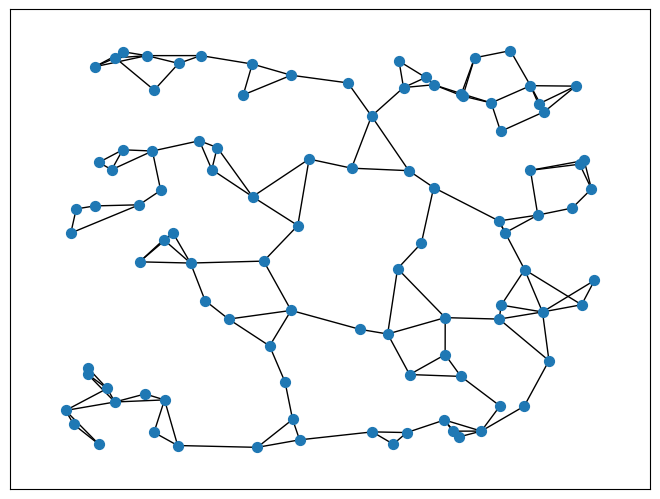

In [693]:
weight = graph.calculate_weight(1, 2)
pos = {i: (graph.get_points()[i].get("x"), graph.get_points()[i].get("y")) for i in graph.get_points()}

G = nx.Graph(np.array(weight))
nx.draw(G, node_size=50, pos=pos)
plt.axis("on")
plt.show()

In [694]:
def random_connected_partitions(graph, adjacency_matrix, num_partitions):
    G = nx.Graph(np.array(adjacency_matrix))
    G_full = nx.Graph(np.array(adjacency_matrix))

    def bfs_limit(graph, source, min_size):
        visited = set()
        queue = [source]

        while queue and len(visited) < min_size:
            node = queue.pop(0)
            if node not in visited:
                visited.add(node)
                queue.extend(neighbor for neighbor in graph.neighbors(node) if neighbor not in visited)

        return visited
        
    nodes = list(G.nodes())

    partition_size = len(nodes) // num_partitions // 2
    partitions = []
    current_degree = 1

    for i in range(num_partitions):
        degree = {}
        for j in G.nodes():
            temp = degree.get(G.degree(j), np.array([]))
            temp = np.append(temp, int(j))
            np.random.shuffle(temp)
            degree[G.degree(j)] = temp
            
        while True:
            if(len(degree.get(current_degree, [])) == 0):
                current_degree += 1
            else: 
                temp = degree.get(current_degree)
                np.random.shuffle(temp)

                start_node = degree.get(current_degree)[0]
                break

        partition = list(bfs_limit(G, start_node, partition_size))
        G.remove_nodes_from(partition)
        partitions.append(partition)
        
    while (len(G.nodes())):
        updated_node = []
        for i in G.nodes():
            index, min_partition = -1, -1
            for j, val in enumerate([n for n in G_full.neighbors(i)]):
                for k, val_p in enumerate(partitions): 
                    if(val in val_p and min_partition == -1):
                        index = k
                        min_partition = len(val_p)
                    elif(val in val_p and len(val_p) < min_partition):
                        index = k
                        min_partition = len(val_p)
            if(min_partition != -1):
                updated_node.append(i)
                partitions[index].append(i)
        G.remove_nodes_from(updated_node)

    partition_vector = np.zeros(len(nodes), dtype=int)
    for i, partition in enumerate(partitions):
        partition_vector[[int(j) for j in partition]] = i + 1

    for i, val in enumerate(partition_vector):
        graph.update_partition(i, val)


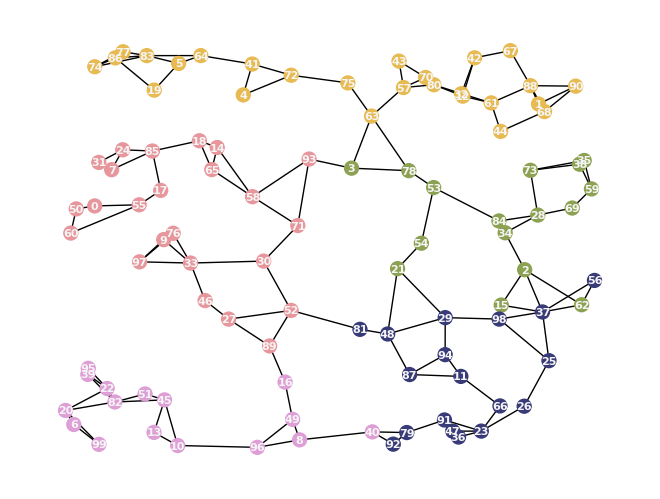

In [695]:
np.random.seed(8)
random_connected_partitions(graph, weight, n_partition)
partition_result = graph.get_partition()
node_colors = [partition_result[node] for node in G.nodes()]
labels = {node: f'{node}' for node in G.nodes()}
label_pos = {k: (v[0], v[1]) for k, v in pos.items()} 

nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='whitesmoke', font_weight='800')

plt.show()

# Optimization 

## Objective Function

In [696]:
def f1_obj(edge_cut):
    sum = 0
    for i in edge_cut: 
        sum += edge_cut.get(i, 0)
    return sum

def f2_obj(graph, n):
    sum = 0
    for i in range(n - 1):
        for j in range(i, n):
            sum += np.abs(graph.get_partition_size(i + 1) - graph.get_partition_size(j + 1)) 
    return sum

def f3_obj(graph, n):
    sum = 0
    for i in range(n):
        sum += graph.get_partition_spread(i + 1)
    return sum

## Selection 

In [697]:
n_population = 3
populations = np.array([])
partition_results = np.array([])

for i in tqdm(range(n_population)):
    new_graph = deepcopy(graph) 
    partition_result = random_connected_partitions(new_graph, weight, n_partition)
    populations = np.append(new_graph, populations)
    partition_results = np.append(partition_results, partition_result)

100%|██████████| 3/3 [00:00<00:00, 274.72it/s]


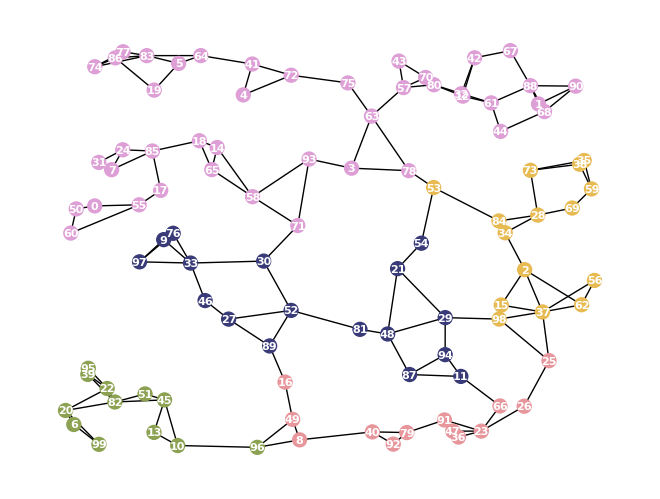

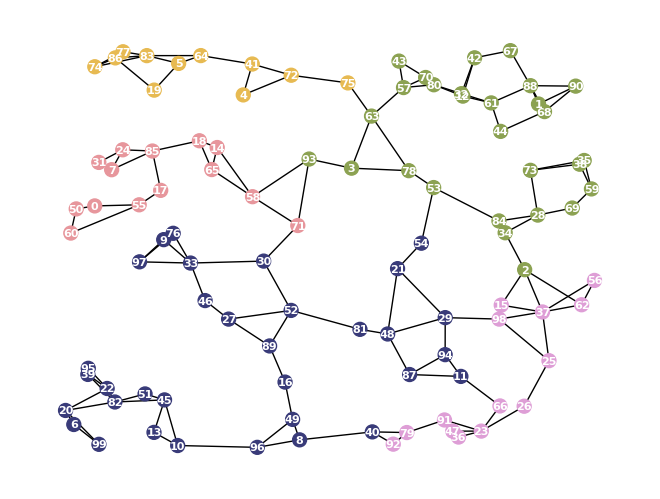

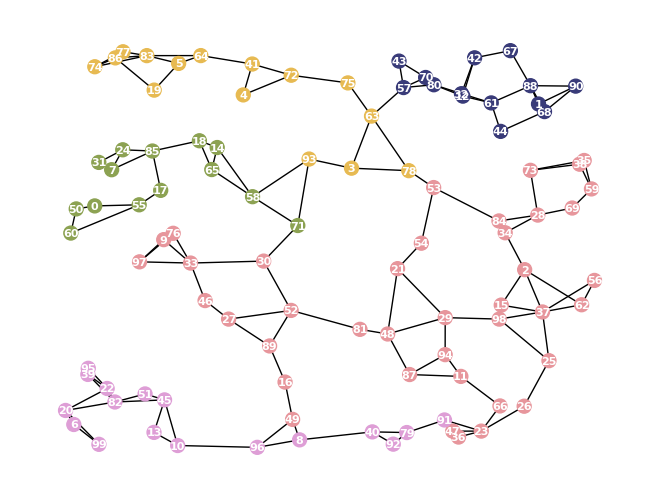

In [698]:
for population in populations:
    partition_result = population.get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    # labels = {node: f'{int(partition_result[node])}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()

In [699]:
for i, population in enumerate(populations):
    print(f"Population-{i + 1}")
    print(f"> f1 = {f1_obj(populations[i].get_edge_cut())}")
    print(f"> f2 = {f2_obj(population, n_partition)}")
    print(f"> f3 = {f3_obj(population, n_partition)}")


Population-1
> f1 = 30.830752122557264
> f2 = 132
> f3 = 87.32057258575765
Population-2
> f1 = 38.640932928886016
> f2 = 116
> f3 = 77.43650283750306
Population-3
> f1 = 25.733535683306023
> f2 = 110
> f3 = 70.69228995171284


## Mutation

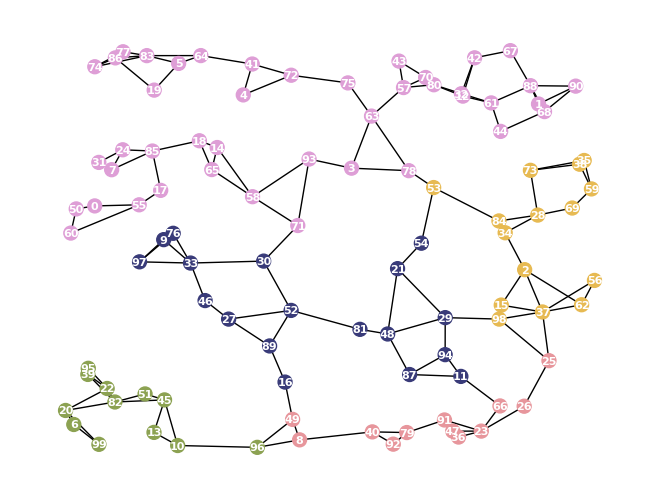

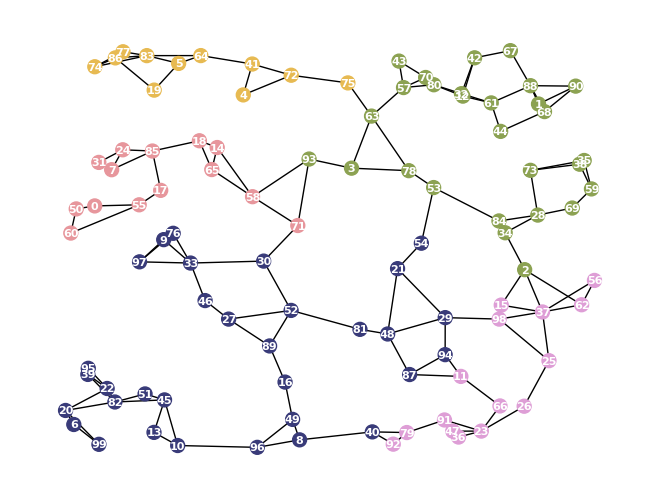

In [700]:
for population in populations[:2]:
    population.mutate_graph()
    partition_result = population.get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()

In [701]:
for i, population in enumerate(populations):
    print(f"Population-{i + 1}")
    print(f"> f1 = {f1_obj(populations[i].get_edge_cut())}")
    print(f"> f2 = {f2_obj(population, n_partition)}")
    print(f"> f3 = {f3_obj(population, n_partition)}")


Population-1
> f1 = 30.805652530852917
> f2 = 136
> f3 = 87.72803228597036
Population-2
> f1 = 40.27376913927788
> f2 = 112
> f3 = 76.55290446757121
Population-3
> f1 = 25.733535683306023
> f2 = 110
> f3 = 70.69228995171284


## Crossover

In [702]:
print(populations[0].get_partition_points(4))
print(populations[1].get_partition_points(2))

{8: {'x': 13.226246439345687, 'y': 0.9266340086122895, 'partition': 4}, 23: {'x': 23.472480644662294, 'y': 1.5537609575036555, 'partition': 4}, 25: {'x': 27.288938748354813, 'y': 6.609837927232032, 'partition': 4}, 26: {'x': 25.8909873241384, 'y': 3.341111586254428, 'partition': 4}, 36: {'x': 22.189434106770562, 'y': 1.1270323657561576, 'partition': 4}, 40: {'x': 17.32765995515461, 'y': 1.498590262726065, 'partition': 4}, 47: {'x': 21.862301145722924, 'y': 1.551138440184289, 'partition': 4}, 49: {'x': 12.832172087064937, 'y': 2.3950007499185624, 'partition': 4}, 66: {'x': 24.52637509617079, 'y': 3.360559718132958, 'partition': 4}, 79: {'x': 19.271988113256228, 'y': 1.449688687373083, 'partition': 4}, 91: {'x': 21.396822477701534, 'y': 2.353577141186957, 'partition': 4}, 92: {'x': 18.508648031843673, 'y': 0.6172773438652008, 'partition': 4}}
{1: {'x': 26.699473865820973, 'y': 25.033479566736148, 'partition': 2}, 2: {'x': 25.917833277686398, 'y': 13.142153651484925, 'partition': 2}, 3: {

In [703]:
population_a = populations[0]
population_b = populations[1]
population_a_target = 4
population_b_target = 2

temp_a_cross = {}
temp_b_cross = {}

population_a_temp = deepcopy(population_a)
population_b_temp = deepcopy(population_b)

for i in population_a_temp.get_partition_points(population_a_target):
    partition = population_b.get_points().get(i).get('partition')
    val = temp_a_cross.get(partition, 0)
    temp_a_cross[partition] = val + 1

for i in population_b.get_partition_points(max(temp_a_cross, key=temp_a_cross.get)):
    population_b.update_partition(i, 0)
    
for i in population_a_temp.get_partition_points(population_a_target):
    population_b.update_partition(i, max(temp_a_cross, key=temp_a_cross.get))

for i in population_b_temp.get_partition_points(population_b_target):
    partition = population_a.get_points().get(i).get('partition')
    val = temp_b_cross.get(partition, 0)
    temp_b_cross[partition] = val + 1

for i in population_a.get_partition_points(max(temp_b_cross, key=temp_b_cross.get)):
    population_a.update_partition(i, 0)
    
for i in population_b_temp.get_partition_points(population_b_target):
    population_a.update_partition(i, max(temp_a_cross, key=temp_a_cross.get))


In [704]:
population_a.get_partition_points(0)

{0: {'x': 1.6730110410116055, 'y': 17.718347408037697, 'partition': 0},
 4: {'x': 10.04995698849693, 'y': 25.68688862720192, 'partition': 0},
 5: {'x': 6.40503852104132, 'y': 27.948370506480156, 'partition': 0},
 7: {'x': 2.627391808004866, 'y': 20.31740630754929, 'partition': 0},
 14: {'x': 8.579806505930033, 'y': 21.909460542356836, 'partition': 0},
 17: {'x': 5.393531500715127, 'y': 18.835173163180876, 'partition': 0},
 18: {'x': 7.576523505717134, 'y': 22.395550778983104, 'partition': 0},
 19: {'x': 5.026521548697957, 'y': 26.0305773145296, 'partition': 0},
 24: {'x': 3.252693612681586, 'y': 21.74743247184909, 'partition': 0},
 31: {'x': 1.9030554651708655, 'y': 20.841385863841765, 'partition': 0},
 41: {'x': 10.557002055995042, 'y': 27.902906614555107, 'partition': 0},
 50: {'x': 0.6302306828194659, 'y': 17.50326943076113, 'partition': 0},
 55: {'x': 4.179526619754842, 'y': 17.798385213708862, 'partition': 0},
 58: {'x': 10.573276364899435, 'y': 18.380472855227737, 'partition': 0}

In [705]:
population_b.get_partition_points(0)

{11: {'x': 22.321599183642384, 'y': 5.4800860260303565, 'partition': 0},
 15: {'x': 24.59853573528109, 'y': 10.600889042692184, 'partition': 0},
 37: {'x': 26.924518495574898, 'y': 10.106311413486377, 'partition': 0},
 56: {'x': 29.854806287852636, 'y': 12.369320605770717, 'partition': 0},
 62: {'x': 29.130205726437648, 'y': 10.623879406585413, 'partition': 0},
 98: {'x': 24.481819829512983, 'y': 9.594186023783799, 'partition': 0}}

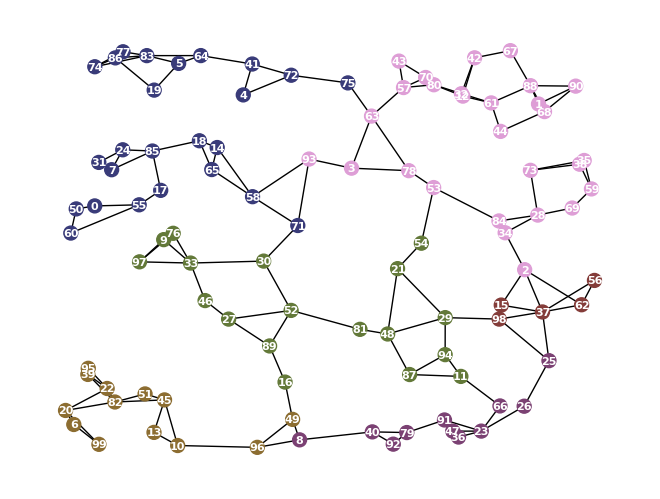

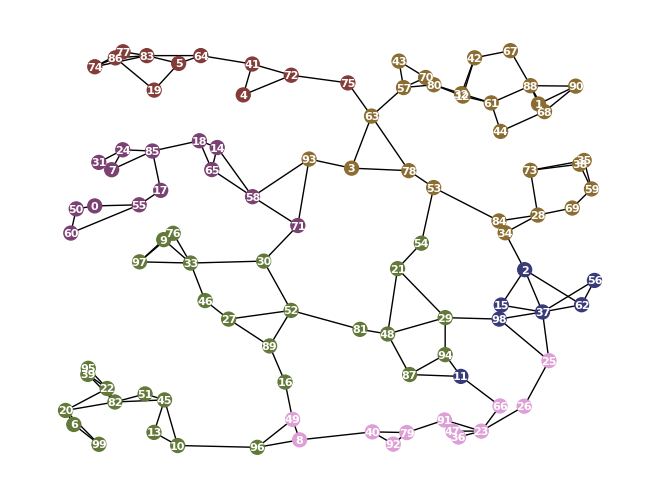

In [706]:
for population in populations[:2]:
    population.mutate_graph()
    partition_result = population.get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()

In [668]:
G = nx.Graph(np.array(population_a.weight))

a_check = False 
b_check = False 

while len(population_a.get_partition_points(0)) > 0 or len(population_b.get_partition_points(0)) > 0:
    population_a_excess = population_a.get_partition_points(0)
    population_b_excess = population_b.get_partition_points(0)
    
    count_null_population_a = 0
    for i in population_a_excess:
        partition_id, min_partition = -1, -1
        for j in [n for n in G.neighbors(i)]:
            partition = population_a.get_points().get(j).get('partition')
            if(min_partition == -1 and (partition != 0 and partition != max(temp_a_cross, key=temp_a_cross.get))):
                partition_id, min_partition = partition, len(population_a.get_partition_points(partition))
            elif(min_partition > len(population_a.get_partition_points(partition)) and (partition != 0 and partition != max(temp_a_cross, key=temp_a_cross.get))):
                partition_id, min_partition = partition, len(population_a.get_partition_points(partition))
        if(min_partition != -1):
            population_a.update_partition(i, partition_id)
        elif(min_partition == -1):
            count_null_population_a += 1
        elif(a_check):
            population_a.update_partition(i, max(temp_a_cross, key=temp_a_cross.get))
    if(count_null_population_a == len(population_a_excess)):
        a_check = True

    count_null_population_b = 0
    for i in population_b_excess:
        partition_id, min_partition = -1, -1
        for j in [n for n in G.neighbors(i)]:
            partition = population_b.get_points().get(j).get('partition')
            if(min_partition == -1 and (partition != 0 or partition != max(temp_b_cross, key=temp_b_cross.get))):
                partition_id, min_partition = partition, len(population_b.get_partition_points(partition))
            elif(min_partition > len(population_b.get_partition_points(partition)) and (partition != 0 and partition != max(temp_b_cross, key=temp_b_cross.get))):
                partition_id, min_partition = partition, len(population_b.get_partition_points(partition))

        if(min_partition != -1):
            population_b.update_partition(i, partition_id)
        elif(min_partition == -1):
            count_null_population_b += 1
        elif(b_check):
            population_b.update_partition(i, max(temp_b_cross, key=temp_b_cross.get))

    if(count_null_partition_b == len(population_b_excess)):
        b_check = True

KeyboardInterrupt: 

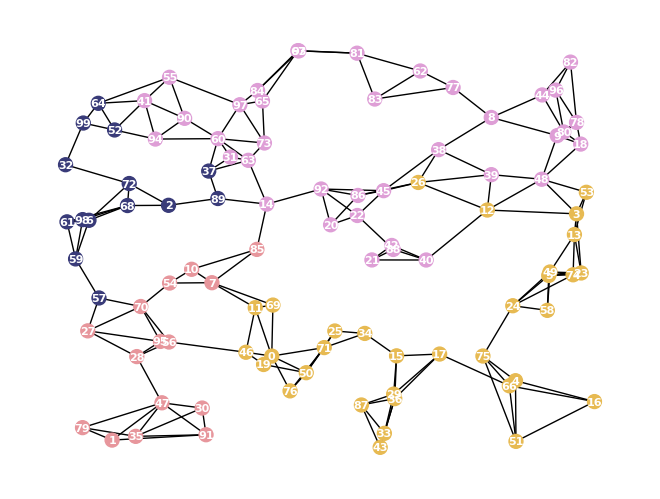

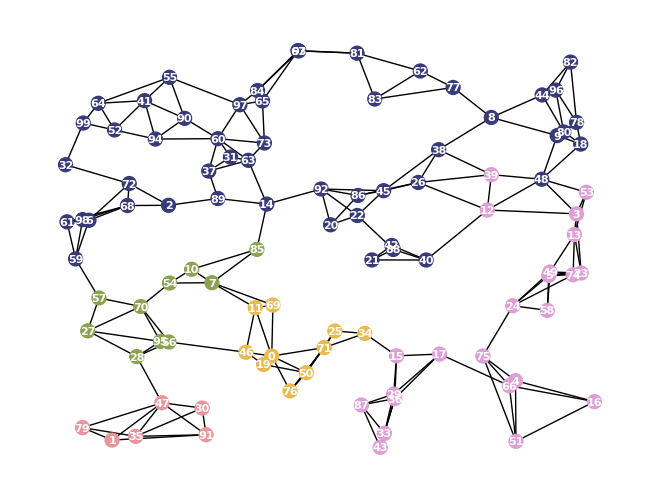

In [622]:
for population in [population_a, population_b]:
    population.mutate_graph()
    partition_result = population.get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()